1. Load fetch_lfw_people from sklearn.datasets. Using sklearn, perform 

- Naives Bayesian
- Logistic Regression
- SVM
- KNN
- Random Forest
- Ensemble Bagging of SVM

Compare them based on 

 1) precision-recall curve, 

 2) Grid search time (if any, e.g., SVM, KNN, trees)

 3) fit time 

Discuss why do you think that particular model works well or does not work well for this data.

=====Balance check====
Colin Powell sample:  236
Donald Rumsfeld sample:  121
George W Bush sample:  530
Gerhard Schroeder sample:  109
Tony Blair sample:  144
Picture of:  Tony Blair
Picture of:  Colin Powell
Picture of:  Colin Powell
Picture of:  Tony Blair
Picture of:  George W Bush
Picture of:  Tony Blair


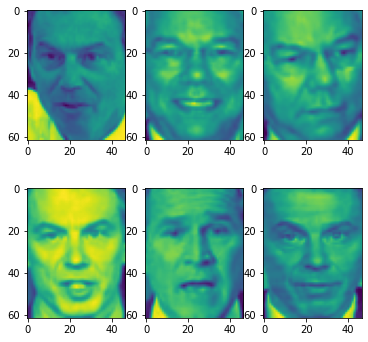

In [1]:
from sklearn.datasets import fetch_lfw_people
# Your code here
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

#default resize is 0.5
#I have made it smaller
lfw_people = fetch_lfw_people(min_faces_per_person=100)

X = lfw_people.data  #already mesh height x width into one
y = lfw_people.target

#(1288, 2914)
n_samples, n_features = X.shape

##make sure X and y shape matches
assert n_samples == y.shape[0]

#image shape.  Can be used for plotting
_, height, width = lfw_people.images.shape

#check how many classes there are
n_classes = len(set(y))
assert n_classes == lfw_people.target_names.shape[0]

#check whether data is imbalanced
#clearly imbalanced!!
print("=====Balance check====")
for i in range(n_classes):
    print(f"{lfw_people.target_names[i]} sample: ", (y[y==i]).shape[0])

#let's plot some image of these people
def plot_image_randomly(X, y, height, width, n_random):
    plt.figure(figsize=(6, 6))
    #reshape into (height, width) for imshow
    for i in range(1, n_random+1):
        plt.subplot(int(np.ceil(n_random/3)), 3, i)
        ix = np.random.randint(X.shape[0])
        print("Picture of: ", lfw_people.target_names[y[ix]])
        plt.imshow(X[ix].reshape(height, width))
    
plot_image_randomly(X, y, height, width, n_random=6)


In [2]:
#Ok, now we finish examining a bit of our data
#let's first split things
# split into a training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [3]:
#copy plot_pr_curve from my lecture
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#add title param
def plot_pr_curve(y_test, y_score, title):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,
                                                         average="micro")    

    plt.plot(recall["micro"], precision["micro"], ":",
            label=f"micro average (area = {average_precision['micro']:.2f})")

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f"Precision-Recall curve of class {i} (area = {average_precision[i]:.2f})")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")

Fit time: 0.02
Predict time: 0.02


'\nWell, images are far from guassian (normal) distribution, thus\nthis not gonna work well with GNB assumption\n'

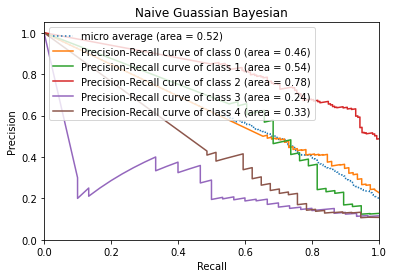

In [4]:
#Bayesian
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.preprocessing import label_binarize

model = GaussianNB()

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Naive Guassian Bayesian")

'''
Well, images are far from guassian (normal) distribution, thus
this not gonna work well with GNB assumption
'''

Fit time: 20.98
Predict time: 0.01


"\nWell, images are input pixels that are linearly combined, thus deriving\nthe output by shifting a linear equation inside sigmoid should perform\npretty well.  Again, it's all about meeting model assumption.\n\nHowever, if you compare LR with other algorithms, fit time is relatively\nmuch longer than other algorithms, likely due to the learning process. \nAnyhow, if we take into account that SVM or RF who achieve similar \naccuracy require long time in finding the right hyperparameters through GridSearchCV,\nit becomes clear that LR is the winner here.\n"

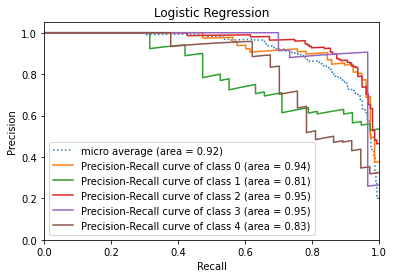

In [5]:
#LR
from sklearn.linear_model import LogisticRegression

#put max_iter to remove the annoying convergence warning
model = LogisticRegression(multi_class="ovr", max_iter=3000,
                          n_jobs=-1)

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Logistic Regression")

'''
Well, images are input pixels that are linearly combined, thus deriving
the output by shifting a linear equation inside sigmoid should perform
pretty well.  Again, it's all about meeting model assumption.

However, if you compare LR with other algorithms, fit time is relatively
much longer than other algorithms, likely due to the learning process. 
Anyhow, if we take into account that SVM or RF who achieve similar 
accuracy require long time in finding the right hyperparameters through GridSearchCV,
it becomes clear that LR is the winner here.
'''

Grid search uses time: 14.05
The best parameters are {'n_neighbors': 7} witha score of 0.62
Fit time: 0.08
Predict time: 0.31


'\nWell...KNN has assumption similar to guassian distribution, i.e.,\nthings nearer to it should share similar features.  Unfortunately,\nthat is not true with images....especially very similar images like\nface.\n\nIn additoin, KNN does not perform any "learning", and thus it may perform\nrelatively worse than other "learning" models such as SVM or logistic\nregression who can learn to fine-tune their weights for complicated\nfeatures\n\nAlso, as expected, predict time takes much more time\nthan fit time, since prediction time is the actual time \nto find the distance of nearby neighbors and sort them....\n'

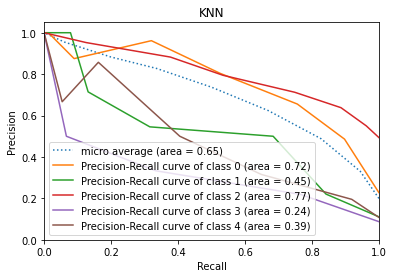

In [6]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_jobs=-1)
param_grid = {"n_neighbors": np.arange(2, 10)}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "KNN")

'''
Well...KNN has assumption similar to guassian distribution, i.e.,
things nearer to it should share similar features.  Unfortunately,
that is not true with images....especially very similar images like
face.

In additoin, KNN does not perform any "learning", and thus it may perform
relatively worse than other "learning" models such as SVM or logistic
regression who can learn to fine-tune their weights for complicated
features

Also, as expected, predict time takes much more time
than fit time, since prediction time is the actual time 
to find the distance of nearby neighbors and sort them....
'''

Grid search uses time: 236.09
The best parameters are {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100} witha score of 0.71
Fit time: 0.57
Predict time: 0.11


"\nWell, random forests is quite robust.  Given unlimited depth of\ntrees, you can imagine it can draw infinite straight line just\nto partition the results.  Here the best param is max_depth = 9,\nand number of trees = 100....but the fit time is quite little!\nAlso since images are pixel-based, I can imagine drawing many \nlines can help.  \n\nHowever, since RF doesn't have any learning, it may perform worst\nthan LogisticRegression or SVM.  But even that, without learning,\nRandom forest is quite impressive. \n\nOne drawback of RF is that it requires great amount of time\nto find the right parameters as seen as the GridSearch time\n\n"

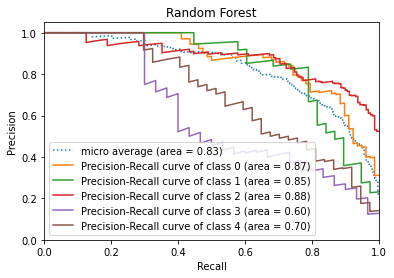

In [7]:
##Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {"n_estimators": [10, 50, 100], 
              "criterion": ["gini", "entropy"],
              "max_depth": np.arange(1, 10),
              "class_weight": ["balanced_subsample", None]}

#put -1 so it gonna use all of my pc cores....
#randomforest can be parallerized thus it supports this feature
model = RandomForestClassifier(n_jobs=-1)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Random Forest")

'''
Well, random forests is quite robust.  Given unlimited depth of
trees, you can imagine it can draw infinite straight line just
to partition the results.  Here the best param is max_depth = 9,
and number of trees = 100....but the fit time is quite little!
Also since images are pixel-based, I can imagine drawing many 
lines can help.  

However, since RF doesn't have any learning, it may perform worst
than LogisticRegression or SVM.  But even that, without learning,
Random forest is quite impressive. 

One drawback of RF is that it requires great amount of time
to find the right parameters as seen as the GridSearch time

'''

Grid search uses time: 458.28
The best parameters are {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'} witha score of 0.83
Fit time: 1.59
Predict time: 0.57


'\nSVM always take long long time!!! to find the right param. But once it identify \nthe right param, the fit and prediction time is relatively less....since it only use few\nsupport vectors to determine the class. SVM also benefits from kernel \ntrick as well as the learning process\n\nKernel is poly thus likely the features are of polynomial degree\nGamma is 0.0001 which is quite now, so we can assume\nthe hyperplane is quite straight.  As for C which is also\nnot that large, it means that our hyperplane also has large\nmargin with the support vectors, which again, suggesting that\nthe data is linearly separable on the polynomial space\n\nOne unexpected thing is that LR beats SVM in terms of accuracy.  The possible explaination\nis that most of the features are linearly combined and thus\ndescent algorithms can eventually find the better weights\n'

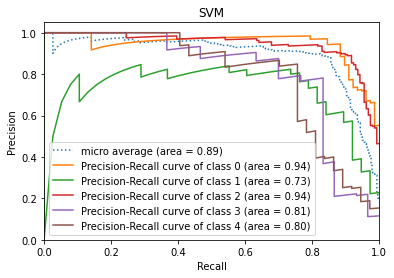

In [8]:
##SVM
from sklearn.svm import SVC # "Support vector classifier"

kernel = ['linear', 'rbf', 'poly']
C_range = [1, 5, 10, 50]
gamma_range = [0.0001, 0.0005, 0.001, 0.005]

param_grid = dict(gamma=gamma_range, C=C_range, 
                  kernel=kernel)

#class_weight='balanced' helps adjust the weight
#sometimes work well for imbalanced dataset
model = SVC(class_weight="balanced")

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.decision_function(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "SVM")

'''
SVM always take long long time!!! to find the right param. But once it identify 
the right param, the fit and prediction time is relatively less....since it only use few
support vectors to determine the class. SVM also benefits from kernel 
trick as well as the learning process

Kernel is poly thus likely the features are of polynomial degree
Gamma is 0.0001 which is quite now, so we can assume
the hyperplane is quite straight.  As for C which is also
not that large, it means that our hyperplane also has large
margin with the support vectors, which again, suggesting that
the data is linearly separable on the polynomial space

One unexpected thing is that LR beats SVM in terms of accuracy.  The possible explaination
is that most of the features are linearly combined and thus
descent algorithms can eventually find the better weights
'''


Grid search uses time: 8960.75
The best parameters are {'base_estimator__C': 10, 'base_estimator__gamma': 0.0005, 'base_estimator__kernel': 'linear', 'n_estimators': 100} witha score of 0.81
Fit time: 18.98
Predict time: 19.37


"\nWell, ensemble of svc comes with a price of long time doing GridSearch.\nFitting time and prediction time also took relatively longer.\nBasically use ensemble of SVM only if you think 1% increase in accuracy matters!\n\n#don't shift-enter this again, Chaky!\n\n"

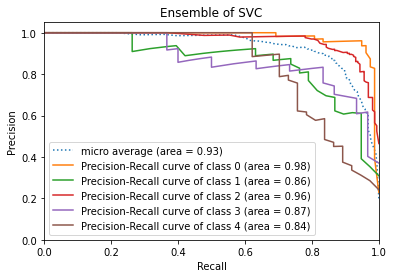

In [9]:
#let's try ensemble of SVC
#I hope that it gonna improve accuracy by little
#but through the process of boostraping, it will reduce
#the time of SVC

from sklearn.ensemble import BaggingClassifier

kernel = ['linear', 'rbf', 'poly']
C_range = [1, 5, 10, 50]
gamma_range = [0.0001, 0.0005, 0.001, 0.005]
n_estimators = [10, 50, 100]

param_grid = dict(base_estimator__gamma=gamma_range, 
                  base_estimator__C=C_range, 
                  base_estimator__kernel=kernel,
                  n_estimators=n_estimators)

#boostraping only 10% for each estimator
#similar to above, we gonna make sure the weights are balanced
model = BaggingClassifier(SVC(class_weight="balanced"), max_samples=0.3)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Ensemble of SVC")

'''
Well, ensemble of svc comes with a price of long time doing GridSearch.
Fitting time and prediction time also took relatively longer.
Basically use ensemble of SVM only if you think 1% increase in accuracy matters!

#don't shift-enter this again, Chaky!

'''

2. Load load_digits from sklearn.datasets.  Compare time and validation score of randomized search and grid search

For search, use the following params

<code>param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}
</code>

'''
What do you think?  Should we use RandomizedSearchCV?
'''

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

X, y = load_digits(return_X_y=True)

In [11]:
# Your code here
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier

import numpy as np

# get some data
X, y = load_digits(return_X_y=True)

# build a classifier
clf = SGDClassifier(loss='hinge', penalty='elasticnet',
                    fit_intercept=True)

# specify parameters and distributions to sample from
param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
print("Score: ", random_search.best_score_)
print("Best params: ", random_search.best_params_)

# use a full grid over all parameters
param_grid = {'average': [True, False],
              'l1_ratio': np.linspace(0, 1, num=10),
              'alpha': np.power(10, np.arange(-4, 1, dtype=float))}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print("Score: ", grid_search.best_score_)
print("Best params: ", grid_search.best_params_)



RandomizedSearchCV took 18.89 seconds for 20 candidates parameter settings.
Score:  0.9293175487465181
Best params:  {'alpha': 0.9143532527452882, 'average': False, 'l1_ratio': 0.00758508906133093}


/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before 

GridSearchCV took 88.29 seconds for 100 candidate parameter settings.
Score:  0.9332219127205199
Best params:  {'alpha': 1.0, 'average': False, 'l1_ratio': 0.0}


3. Load the MNIST data
- Split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing). 
- Train various classifiers, such as a Random Forest classifier, a Logistic Regression classifier, an SVM, and a MLPClassifier (I haven't taught you yet, but its a simple neural network with multi-layers). 
- Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?  
- Last, attemp to use XGBoost.  Does it improve the accuracy?

In [69]:
from sklearn.datasets import fetch_openml
import numpy as np

#fetching
mnist = fetch_openml('mnist_784', version=1)

#make sure is int
mnist.target = mnist.target.astype(np.int)

In [70]:
from sklearn.model_selection import train_test_split

#Load the MNIST data and split it into a training set, a validation set, and 
#a test set (e.g., use 50,000 instances for training, 10,000 for 
#validation, and 10,000 for testing)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [71]:
#define the classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [72]:
models = [rnd_clf, log_clf, svm_clf, mlp_clf]
for model in models:
    print("Training the", model.__class__.__name__)
    model.fit(X_train, y_train)

Training the RandomForestClassifier
Training the LogisticRegression


/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training the SVC
Training the MLPClassifier


In [73]:
[model.score(X_val, y_val) for model in models]

[0.9692, 0.9186, 0.9788, 0.9629]

Seems like Logistic Regression is hurting performance.  Not sure whether we should include it on the ensemble but we will think it later....Let's first define a Voting Classifier

In [74]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("rnd_clf", rnd_clf),
    ("log_clf", log_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)
voting_clf.score(X_val, y_val)

/Users/chaklam/DSAI/Environments/teaching_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9737

In [75]:
#let's print out the individual estimator
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9186, 0.9788, 0.9629]

Clearly, we can see that Logistic Regression is hurting the ensemble performance.  We can easily remove using del or fit again.  

In [76]:
del voting_clf.estimators_[1]  #second estimator

#print estimators to make sure its deleted
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 SVC(probability=True, random_state=42),
 MLPClassifier(random_state=42)]

In [77]:
#check the score again
voting_clf.score(X_val, y_val)  #yay increase a little!

0.9784

By default, voting classifier is hard voting.  Let's try soft voting.  We can either fit again, but we can also easily set params to soft (this works because soft/hard is simply a function of all the models we already fitted)

In [78]:
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)

0.977

Hmm...seems like hard wins....

Finally, let's try on our testing set which we should never touch it until the final testing

In [ ]:
voting_clf.voting = "hard"
print("Voting classifier score:", voting_clf.score(X_test, y_test))
print("Each classifier scor: ")
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

Hmm...it seems that the voting classifier only slighly increase the accuracy by little, when compared to the best estimator

let's try XGBoost

In [ ]:
import xgboost

xgb_clf = xgboost.XGBClassifier() 

#not improved after 2 iterations
xgb_clf.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
print("Score: ", xgb_clf.score(X_test, y_test))